# MNE library install

In [ ]:
!pip install mne
!pip install mne-features
!pip install yasa

# Import libary

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import mne
import os
import mne_features
import yasa

from mne.time_frequency import psd_welch
from scipy import signal
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Data Load

(ref)
https://mne.tools/0.16/auto_tutorials/plot_introduction.html

In [ ]:
epilepsy_data_folder = '/content/drive/My Drive/Colab Notebooks/EEG/Dataset/EPILEPSY/'
noepilepsy_data_folder = '/content/drive/My Drive/Colab Notebooks/EEG/Dataset/NO EPILEPSY/'
epfnames = os.listdir(epilepsy_data_folder)[:-1]
noepfnames = os.listdir(noepilepsy_data_folder)[:-1]
channels = dict()
epraws = []
noepraws = []
for f in epfnames:
  epraw = mne.io.read_raw_edf(epilepsy_data_folder+f, preload=True)
  epraws.append(epraw)
  for ch in epraw.info['ch_names']:
    if ch in channels:
      channels[ch] += 1
    else:
      channels[ch] = 1
for f in noepfnames:
  noepraw = mne.io.read_raw_edf(noepilepsy_data_folder+f, preload=True)
  noepraws.append(noepraw)


Extracting EDF parameters from /content/drive/My Drive/Colab Notebooks/EEG/Dataset/EPILEPSY/00000355_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 303499  =      0.000 ...  1213.996 secs...
Extracting EDF parameters from /content/drive/My Drive/Colab Notebooks/EEG/Dataset/EPILEPSY/00000355_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 32499  =      0.000 ...   129.996 secs...
Extracting EDF parameters from /content/drive/My Drive/Colab Notebooks/EEG/Dataset/EPILEPSY/00000355_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312999  =      0.000 ...  1251.996 secs...
Extracting EDF parameters from /content/drive/My Drive/Colab Notebooks/EEG/Dataset/EPILEPSY/00000592_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 332249  =   

In [ ]:
print(len(epfnames))
print(channels)
print(epfnames)
print(len(noepfnames))

# picks : 24 channels that every raw have
picks = [ch for ch in channels if channels[ch] >= len(epfnames)]
print(picks)
print(len(picks))


print(epraws[0])
print(epraws[0].info)
print(epraws[0]['data'])
print(len(epraws[0]['data'][0][0]))

97
{'EEG FP1-LE': 97, 'EEG FP2-LE': 97, 'EEG F3-LE': 97, 'EEG F4-LE': 97, 'EEG C3-LE': 97, 'EEG C4-LE': 97, 'EEG A1-LE': 97, 'EEG A2-LE': 97, 'EEG P3-LE': 97, 'EEG P4-LE': 97, 'EEG O1-LE': 97, 'EEG O2-LE': 97, 'EEG F7-LE': 97, 'EEG F8-LE': 97, 'EEG T3-LE': 97, 'EEG T4-LE': 97, 'EEG T5-LE': 97, 'EEG T6-LE': 97, 'EEG FZ-LE': 97, 'EEG CZ-LE': 97, 'EEG PZ-LE': 97, 'EEG OZ-LE': 97, 'EEG PG1-LE': 88, 'EEG PG2-LE': 88, 'EEG EKG-LE': 97, 'EEG SP2-LE': 10, 'EEG SP1-LE': 10, 'EEG 28-LE': 93, 'EEG 29-LE': 93, 'EEG 30-LE': 97, 'EEG T1-LE': 19, 'EEG T2-LE': 19, 'PHOTIC PH': 88, 'EEG 26-LE': 87, 'EEG 27-LE': 87, 'EEG 31-LE': 78, 'EEG 32-LE': 78, 'DC1-DC': 78, 'DC2-DC': 78, 'DC3-DC': 78, 'DC4-DC': 78, 'DC5-DC': 78, 'DC6-DC': 78, 'DC7-DC': 78, 'DC8-DC': 78, 'EEG RLC-LE': 4, 'EEG LUC-LE': 4, 'EEG 23-LE': 9, 'EEG 24-LE': 9}
['00000355_s001_t001.edf', '00000355_s002_t000.edf', '00000355_s002_t001.edf', '00000592_s001_t001.edf', '00000592_s002_t000.edf', '00000767_s001_t000.edf', '00000883_s001_t002.edf',

# Preprocessing

####Common spatial patterns(CSP) : channel selection
####Independent Component Analysis(ICA) : remove artifacts or select latent sources
####**Power spectral density(PSD)**
####**Bandpower : Delta, Theta, Alpha, Beta, Sigma, Gamma, TotalAbsPow**, FreqResponse, Relative
####Signal Space Projection(SSP) : remove ECG and EOG artifacts
####Maxwell Filters:(Signal Space Separation, SSS) : remove environmental noise
####Dipole Fit
####mne_features.feature_extraction.FeatureExtractor

####dataset :
channel - bandpower : channel * (8 columns - Delta, Theta, Alpha, Sigma, Beta, Gamma, TotalAbsPow, FreqResponse)
psd infomation
label - epilepsy / no epilepsy

In [ ]:
import pandas as pd
raw = epraws[0]
raw.pick_channels(picks)
bp = yasa.bandpower(raw)
bp = bp.drop(['Relative'], axis=1)
data = dict()
for row in bp.index:
  for col in bp.columns:
    data[row+' '+col] = bp[col][row]
psds, freqs = psd_welch(raw)
chidc = raw.ch_names
psds /= np.sum(psds, axis=-1, keepdims=True)
for chidx, chidx_name in enumerate(chidc):
  for fridx, freq in enumerate(freqs):
    data[chidx_name +' freq '+ str(round(freq,2))] = psds[chidx][fridx]
data['label'] = 'epilepsy'
print(data)
df_data = pd.DataFrame(data, index = [0])
print(df_data)

Effective window size : 1.024 (s)
{'EEG FP1-LE Delta': 0.6217875068547312, 'EEG FP1-LE Theta': 0.1986071060246114, 'EEG FP1-LE Alpha': 0.1264834207978485, 'EEG FP1-LE Sigma': 0.01569785389188267, 'EEG FP1-LE Beta': 0.027992594566440657, 'EEG FP1-LE Gamma': 0.009431517864485534, 'EEG FP1-LE TotalAbsPow': 215.45575921456896, 'EEG FP1-LE FreqRes': 0.25, 'EEG FP2-LE Delta': 0.6506949612245662, 'EEG FP2-LE Theta': 0.18049288009304526, 'EEG FP2-LE Alpha': 0.11809920811089, 'EEG FP2-LE Sigma': 0.014648507239034214, 'EEG FP2-LE Beta': 0.026365815082715204, 'EEG FP2-LE Gamma': 0.00969862824974951, 'EEG FP2-LE TotalAbsPow': 224.51426806056318, 'EEG FP2-LE FreqRes': 0.25, 'EEG F3-LE Delta': 0.2899780708820961, 'EEG F3-LE Theta': 0.32550112903127304, 'EEG F3-LE Alpha': 0.26196529712272765, 'EEG F3-LE Sigma': 0.03679755612992186, 'EEG F3-LE Beta': 0.06572372785628466, 'EEG F3-LE Gamma': 0.02003421897769655, 'EEG F3-LE TotalAbsPow': 122.10178141702325, 'EEG F3-LE FreqRes': 0.25, 'EEG F4-LE Delta': 0

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

datas = []
patient_no = 0
print('EPILEPSY')
for raw in epraws:
  print('-------------------------------------------------------')
  print(patient_no)
  raw.pick_channels(picks)
  print('psd plot')
  raw.plot_psd()
  print('raw plot')
  raw.plot()
  data = dict()

  bp = yasa.bandpower(raw)
  bp = bp.drop(['Relative'], axis=1)
  for row in bp.index:
    for col in bp.columns:
      data[row+' '+col] = bp[col][row]
  chidc = raw.ch_names
  psds, freqs = psd_welch(raw)
  psds /= np.sum(psds, axis=-1, keepdims=True)
  for chidx, chidx_name in enumerate(chidc):
    for fridx, freq in enumerate(freqs):
      data[chidx_name +' freq '+ str(round(freq,2))] = psds[chidx][fridx]
  data['label'] = 'epilepsy'
  print('psd')
  print(psds)
  print('freq')
  print(freqs)
  print('bandpower')
  print(bp)
  df_data = pd.DataFrame(data, index = [patient_no])
  patient_no += 1
  if len(datas) == 0:
    datas = df_data
  else:
    datas = pd.concat([datas, df_data])

print('NO EPILEPSY')
for raw in noepraws:
  print('-------------------------------------------------------')
  raw.pick_channels(picks)
  print('psd plot')
  raw.plot_psd()
  print('raw plot')
  raw.plot()
  data = dict()

  bp = yasa.bandpower(raw)
  bp = bp.drop(['Relative'], axis=1)
  for row in bp.index:
    for col in bp.columns:
      data[row+' '+col] = bp[col][row]
  chidc = raw.ch_names
  psds, freqs = psd_welch(raw)
  psds /= np.sum(psds, axis=-1, keepdims=True)
  for chidx, chidx_name in enumerate(chidc):
    for fridx, freq in enumerate(freqs):
      data[chidx_name +' freq '+ str(round(freq,2))] = psds[chidx][fridx]
  data['label'] = 'no epilepsy'
  
  print('psd')
  print(psds)
  print('freq')
  print(freqs)
  print('bandpower')
  print(bp)
  df_data = pd.DataFrame(data, index = [patient_no])
  patient_no += 1
  datas = pd.concat([datas, df_data])
print(datas)

PSD (flatten) + Bandpower(flatten) + Label
###Example
channel = 24
- Bandpower flatten = 8 * 24 = 192
- PSD flatten = 24 * 129 = 3,096
- label = 1
- data : 192 + 3,096 + 1 = 3,288 + 1 columns

# Prepare Train and Test Data and Label

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

X = datas.drop(['label'], axis=1)
print(X)

imp = SimpleImputer(missing_values=np.nan, strategy = 'constant', fill_value = 0)
imp = imp.fit(X)

X = imp.transform(X)

y = datas['label']
class_le = LabelEncoder()
class_le.fit(['epilepsy', 'no epilepsy'])
print(class_le.classes_)
y = class_le.transform(y)

scoring = ['accuracy', 'recall', 'precision', 'f1']

max_estimator_dict = dict()
mean_dict = dict()
max_dict = dict()

print(X)
print(y)


     EEG FP1-LE Delta  ...  EEG 30-LE freq 125.0
0            0.621788  ...          4.464824e-07
1            0.649229  ...          3.284036e-06
2            0.648733  ...          2.411022e-07
3            0.608450  ...          2.550734e-05
4            0.393763  ...          2.161948e-06
..                ...  ...                   ...
126          0.937464  ...          1.140082e-06
127          0.975566  ...          5.417999e-08
128          0.206481  ...          2.042572e-07
129          0.960478  ...          1.686899e-06
130          0.842962  ...          6.151889e-07

[131 rows x 3288 columns]
['epilepsy' 'no epilepsy']
[[6.21787507e-01 1.98607106e-01 1.26483421e-01 ... 8.59676227e-07
  9.01101887e-07 4.46482375e-07]
 [6.49229150e-01 1.83747324e-01 1.08898511e-01 ... 6.38964016e-06
  6.44612529e-06 3.28403592e-06]
 [6.48732517e-01 1.79749032e-01 1.08575572e-01 ... 3.07717806e-07
  8.01407815e-07 2.41102176e-07]
 ...
 [2.06480996e-01 5.43026808e-02 2.14094355e-01 ... 4.073

# Model Learning


### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
logistic_reg_pipe = Pipeline([('scaler',StandardScaler()), ('clf', LogisticRegression(multi_class='auto', solver = 'liblinear', random_state = 42))])
logistic_reg_pipe.fit(X, y)
scores = cross_validate(logistic_reg_pipe, X, y, scoring = scoring, cv = 3, return_estimator = True)

max_estimator_dict['logistic regression'] = scores['estimator'][scores['test_accuracy'].argmax()]
mean_dict['logistic regression'] = [scores['test_accuracy'].mean(), scores['test_recall'].mean(), scores['test_precision'].mean(), scores['test_f1'].mean()]
max_dict['logistic regression'] = [scores['test_accuracy'].max(), scores['test_recall'].max(), scores['test_precision'].max(), scores['test_f1'].max()]

### Ridge Classifier

In [ ]:
from sklearn.linear_model import RidgeClassifier
ridge_reg_pipe = Pipeline([('scaler',StandardScaler()), ('clf', RidgeClassifier(random_state = 42))])
ridge_reg_pipe.fit(X, y)
scores = cross_validate(ridge_reg_pipe, X, y, scoring = scoring, cv = 3, return_estimator = True)

max_estimator_dict['ridge regression'] = scores['estimator'][scores['test_accuracy'].argmax()]
mean_dict['ridge regression'] = [scores['test_accuracy'].mean(), scores['test_recall'].mean(), scores['test_precision'].mean(), scores['test_f1'].mean()]
max_dict['ridge regression'] = [scores['test_accuracy'].max(), scores['test_recall'].max(), scores['test_precision'].max(), scores['test_f1'].max()]

### Support Vector Classifier

In [ ]:
from sklearn.svm import SVC
svm_pipe = Pipeline([('scaler',StandardScaler()), ('clf', SVC(random_state = 42))])
svm_pipe.fit(X, y)
scores = cross_validate(svm_pipe, X, y, scoring = scoring, cv = 3, return_estimator = True)

max_estimator_dict['SVC'] = scores['estimator'][scores['test_accuracy'].argmax()]
mean_dict['SVC'] = [scores['test_accuracy'].mean(), scores['test_recall'].mean(), scores['test_precision'].mean(), scores['test_f1'].mean()]
max_dict['SVC'] = [scores['test_accuracy'].max(), scores['test_recall'].max(), scores['test_precision'].max(), scores['test_f1'].max()]

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Linear Support Vector Classifier

In [ ]:
from sklearn.svm import LinearSVC
linear_svm_pipe = Pipeline([('scaler',StandardScaler()), ('clf', LinearSVC(multi_class='crammer_singer', max_iter=10000, random_state = 42))])
linear_svm_pipe.fit(X, y)
scores = cross_validate(linear_svm_pipe, X, y, scoring = scoring, cv = 3, return_estimator = True)

max_estimator_dict['Linear SVC'] = scores['estimator'][scores['test_accuracy'].argmax()]
mean_dict['Linear SVC'] = [scores['test_accuracy'].mean(), scores['test_recall'].mean(), scores['test_precision'].mean(), scores['test_f1'].mean()]
max_dict['Linear SVC'] = [scores['test_accuracy'].max(), scores['test_recall'].max(), scores['test_precision'].max(), scores['test_f1'].max()]

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
random_forest_pipe = Pipeline([('scaler',StandardScaler()), ('clf', RandomForestClassifier(random_state = 42))])
random_forest_pipe.fit(X, y)
scores = cross_validate(random_forest_pipe, X, y, scoring = scoring, cv = 3, return_estimator = True)

max_estimator_dict['random forest'] = scores['estimator'][scores['test_accuracy'].argmax()]
mean_dict['random forest'] = [scores['test_accuracy'].mean(), scores['test_recall'].mean(), scores['test_precision'].mean(), scores['test_f1'].mean()]
max_dict['random forest'] = [scores['test_accuracy'].max(), scores['test_recall'].max(), scores['test_precision'].max(), scores['test_f1'].max()]

Bernoulli Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB
bernoulli_nb_pipe = Pipeline([('scaler',StandardScaler()), ('clf', BernoulliNB())])
bernoulli_nb_pipe.fit(X, y)
scores = cross_validate(bernoulli_nb_pipe, X, y, scoring = scoring, cv = 3, return_estimator = True)

max_estimator_dict['bernoulli NB'] = scores['estimator'][scores['test_accuracy'].argmax()]
mean_dict['bernoulli NB'] = [scores['test_accuracy'].mean(), scores['test_recall'].mean(), scores['test_precision'].mean(), scores['test_f1'].mean()]
max_dict['bernoulli NB'] = [scores['test_accuracy'].max(), scores['test_recall'].max(), scores['test_precision'].max(), scores['test_f1'].max()]

### Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
gaussian_nb_pipe = Pipeline([('scaler',StandardScaler()), ('clf', GaussianNB())])
gaussian_nb_pipe.fit(X, y)
scores = cross_validate(gaussian_nb_pipe, X, y, scoring = scoring, cv = 3, return_estimator = True)

max_estimator_dict['gaussian NB'] = scores['estimator'][scores['test_accuracy'].argmax()]
mean_dict['gaussian NB'] = [scores['test_accuracy'].mean(), scores['test_recall'].mean(), scores['test_precision'].mean(), scores['test_f1'].mean()]
max_dict['gaussian NB'] = [scores['test_accuracy'].max(), scores['test_recall'].max(), scores['test_precision'].max(), scores['test_f1'].max()]

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
decision_tree_pipe = Pipeline([('scaler',StandardScaler()), ('clf', DecisionTreeClassifier(random_state = 42))])
decision_tree_pipe.fit(X, y)
scores = cross_validate(decision_tree_pipe, X, y, scoring = scoring, cv = 3, return_estimator = True)

max_estimator_dict['decision tree'] = scores['estimator'][scores['test_accuracy'].argmax()]
mean_dict['decision tree'] = [scores['test_accuracy'].mean(), scores['test_recall'].mean(), scores['test_precision'].mean(), scores['test_f1'].mean()]
max_dict['decision tree'] = [scores['test_accuracy'].max(), scores['test_recall'].max(), scores['test_precision'].max(), scores['test_f1'].max()]

### Extra Tree

In [ ]:
from sklearn.tree import ExtraTreeClassifier
extra_tree_pipe = Pipeline([('scaler',StandardScaler()), ('clf', ExtraTreeClassifier(random_state = 42))])
extra_tree_pipe.fit(X, y)
scores = cross_validate(extra_tree_pipe, X, y, scoring = scoring, cv = 3, return_estimator = True)

max_estimator_dict['extra tree'] = scores['estimator'][scores['test_accuracy'].argmax()]
mean_dict['extra tree'] = [scores['test_accuracy'].mean(), scores['test_recall'].mean(), scores['test_precision'].mean(), scores['test_f1'].mean()]
max_dict['extra tree'] = [scores['test_accuracy'].max(), scores['test_recall'].max(), scores['test_precision'].max(), scores['test_f1'].max()]

### K Neighbors Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
kneighbors_pipe = Pipeline([('scaler',StandardScaler()), ('clf', KNeighborsClassifier(n_neighbors=5))])
kneighbors_pipe.fit(X, y)
scores = cross_validate(kneighbors_pipe, X, y, scoring = scoring, cv = 3, return_estimator = True)

max_estimator_dict['k neighbors'] = scores['estimator'][scores['test_accuracy'].argmax()]
mean_dict['k neighbors'] = [scores['test_accuracy'].mean(), scores['test_recall'].mean(), scores['test_precision'].mean(), scores['test_f1'].mean()]
max_dict['k neighbors'] = [scores['test_accuracy'].max(), scores['test_recall'].max(), scores['test_precision'].max(), scores['test_f1'].max()]

### Nearest Centroid

In [ ]:
from sklearn.neighbors import NearestCentroid
nearest_centroid_pipe = Pipeline([('scaler',StandardScaler()), ('clf', NearestCentroid())])
nearest_centroid_pipe.fit(X, y)
scores = cross_validate(nearest_centroid_pipe, X, y, scoring = scoring, cv = 3, return_estimator = True)

max_estimator_dict['nearest centroid'] = scores['estimator'][scores['test_accuracy'].argmax()]
mean_dict['nearest centroid'] = [scores['test_accuracy'].mean(), scores['test_recall'].mean(), scores['test_precision'].mean(), scores['test_f1'].mean()]
max_dict['nearest centroid'] = [scores['test_accuracy'].max(), scores['test_recall'].max(), scores['test_precision'].max(), scores['test_f1'].max()]

### Multi-Layer Perceptron Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp_pipe = Pipeline([('scaler',StandardScaler()), ('clf', MLPClassifier(random_state = 42))])
mlp_pipe.fit(X, y)
scores = cross_validate(mlp_pipe, X, y, scoring = scoring, cv = 3, return_estimator = True)

max_estimator_dict['mlp'] = scores['estimator'][scores['test_accuracy'].argmax()]
mean_dict['mlp'] = [scores['test_accuracy'].mean(), scores['test_recall'].mean(), scores['test_precision'].mean(), scores['test_f1'].mean()]
max_dict['mlp'] = [scores['test_accuracy'].max(), scores['test_recall'].max(), scores['test_precision'].max(), scores['test_f1'].max()]

## Mean Accuracy Rank

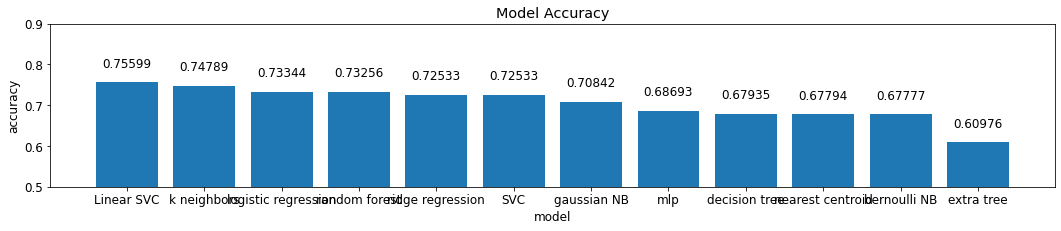

In [ ]:
mean_accuracy = [(x, round(mean_dict[x][0], 5)) for x in mean_dict.keys()]
mean_accuracy.sort(key = lambda x:x[1], reverse=True)
plt.figure(figsize=(18,3))
plt.ylim(0.5,0.9)
plt.bar(*zip(*mean_accuracy))
for x, y in mean_accuracy:
  plt.text(x, y, str(y)+'\n', horizontalalignment='center')
plt.xlabel("model")
plt.ylabel("accuracy")
plt.title("Model Accuracy")
plt.show()

## Mean Recall Rank

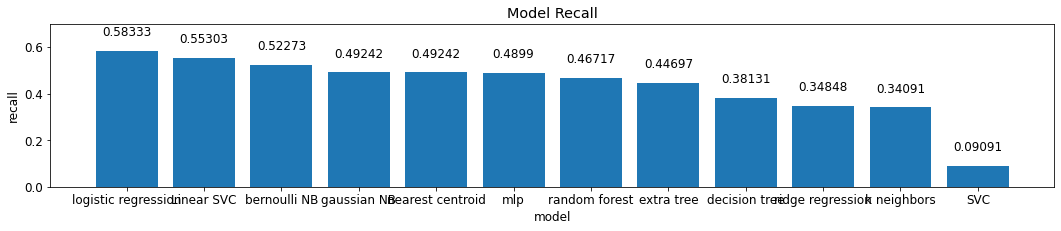

In [ ]:
mean_recall = [(x, round(mean_dict[x][1], 5)) for x in mean_dict.keys()]
mean_recall.sort(key = lambda x:x[1], reverse=True)
plt.figure(figsize=(18,3))
plt.ylim(0.0,0.7)
plt.bar(*zip(*mean_recall))
for x, y in mean_recall:
  plt.text(x, y, str(y)+'\n', horizontalalignment='center')
plt.xlabel("model")
plt.ylabel("recall")
plt.title("Model Recall")
plt.show()

## Mean Precision Rank

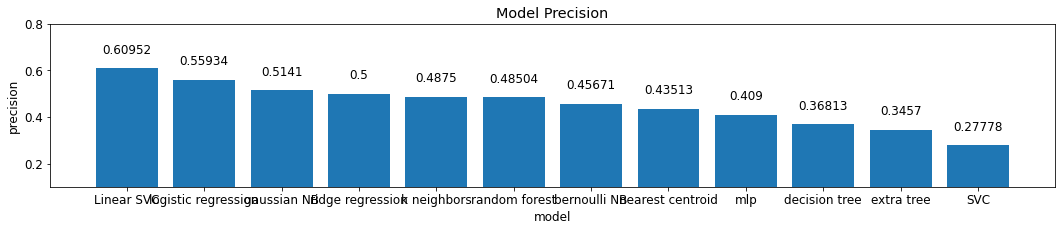

In [ ]:
mean_precision = [(x, round(mean_dict[x][2], 5)) for x in mean_dict.keys()]
mean_precision.sort(key = lambda x:x[1], reverse=True)
plt.figure(figsize=(18,3))
plt.ylim(0.1,0.8)
plt.bar(*zip(*mean_precision))
for x, y in mean_precision:
  plt.text(x, y, str(y)+'\n', horizontalalignment='center')
plt.xlabel("model")
plt.ylabel("precision")
plt.title("Model Precision")
plt.show()

## Mean F1 Rank

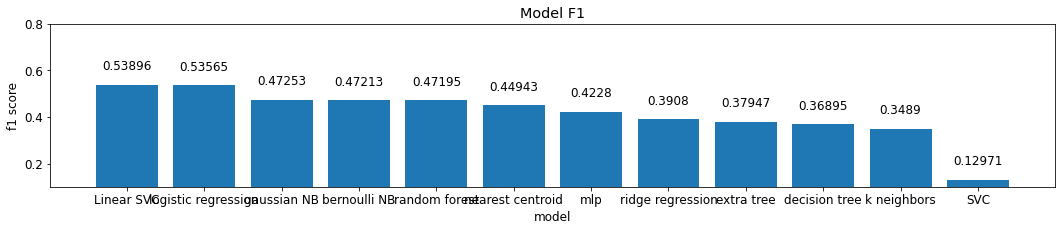

In [ ]:
mean_f1 = [(x, round(mean_dict[x][3], 5)) for x in mean_dict.keys()]
mean_f1.sort(key = lambda x:x[1], reverse=True)
plt.figure(figsize=(18,3))
plt.ylim(0.1,0.8)
plt.bar(*zip(*mean_f1))
for x, y in mean_f1:
  plt.text(x, y, str(y)+'\n', horizontalalignment='center')
plt.xlabel("model")
plt.ylabel("f1 score")
plt.title("Model F1")
plt.show()

## Max Accuracy Rank

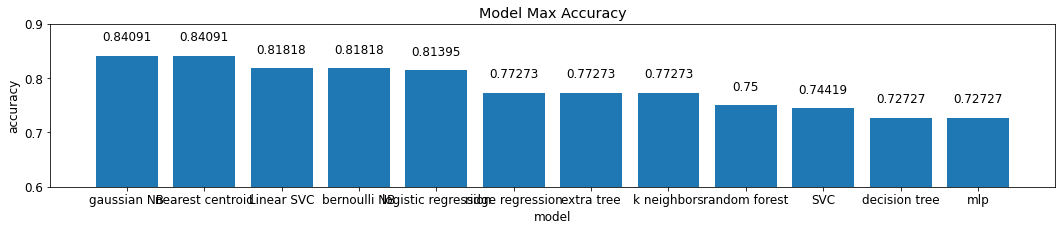

In [ ]:
max_accuracy = [(x, round(max_dict[x][0], 5)) for x in max_dict.keys()]
max_accuracy.sort(key = lambda x:x[1], reverse=True)
plt.figure(figsize=(18,3))
plt.ylim(0.6,0.9)
plt.bar(*zip(*max_accuracy))
for x, y in max_accuracy:
  plt.text(x, y, str(y)+'\n', horizontalalignment='center')
plt.xlabel("model")
plt.ylabel("accuracy")
plt.title("Model Max Accuracy")
plt.show()

## Max Recall Rank

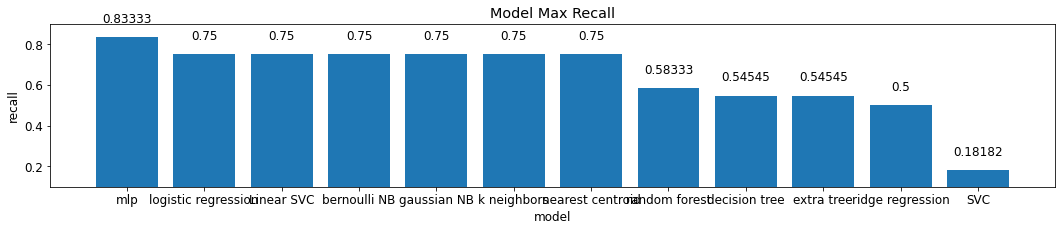

In [ ]:
max_recall = [(x, round(max_dict[x][1], 5)) for x in max_dict.keys()]
max_recall.sort(key = lambda x:x[1], reverse=True)
plt.figure(figsize=(18,3))
plt.ylim(0.1,0.9)
plt.bar(*zip(*max_recall))
for x, y in max_recall:
  plt.text(x, y, str(y)+'\n', horizontalalignment='center')
plt.xlabel("model")
plt.ylabel("recall")
plt.title("Model Max Recall")
plt.show()

## Max Precision Rank

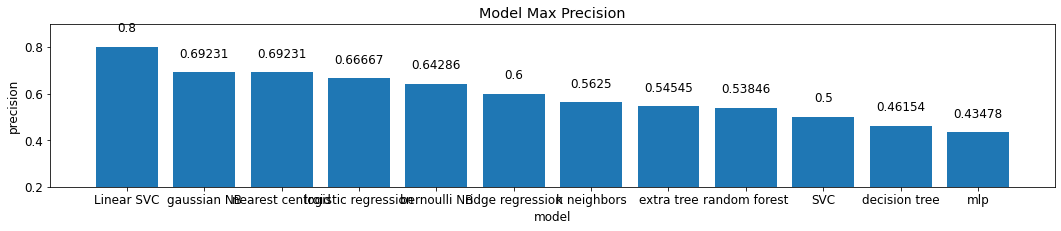

In [ ]:
max_precision = [(x, round(max_dict[x][2], 5)) for x in max_dict.keys()]
max_precision.sort(key = lambda x:x[1], reverse=True)
plt.figure(figsize=(18,3))
plt.ylim(0.2,0.9)
plt.bar(*zip(*max_precision))
for x, y in max_precision:
  plt.text(x, y, str(y)+'\n', horizontalalignment='center')
plt.xlabel("model")
plt.ylabel("precision")
plt.title("Model Max Precision")
plt.show()

## Max F1 Rank


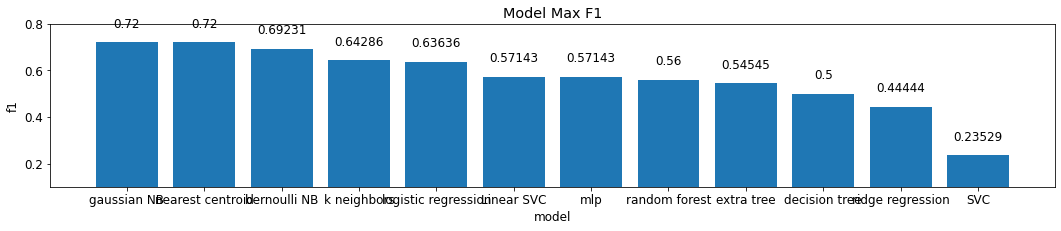

In [ ]:
max_f1 = [(x, round(max_dict[x][3], 5)) for x in max_dict.keys()]
max_f1.sort(key = lambda x:x[1], reverse=True)
plt.figure(figsize=(18,3))
plt.ylim(0.1,0.8)
plt.bar(*zip(*max_f1))
for x, y in max_f1:
  plt.text(x, y, str(y)+'\n', horizontalalignment='center')
plt.xlabel("model")
plt.ylabel("f1")
plt.title("Model Max F1")
plt.show()

## GridSearch Linear SVC and MLP

In [ ]:
X = datas.drop(['label'], axis=1)
print(X)

imp = SimpleImputer(missing_values=np.nan, strategy = 'constant', fill_value = 0)
imp = imp.fit(X)

X = imp.transform(X)

y = datas['label']
class_le = LabelEncoder()
class_le.fit(['epilepsy', 'no epilepsy'])
print(class_le.classes_)
y = class_le.transform(y)

scoring = ['accuracy', 'recall', 'precision', 'f1']

max_estimator_dict = dict()
mean_dict = dict()
max_dict = dict()

print(X)
print(y)

     EEG FP1-LE Delta  ...  EEG 30-LE freq 125.0
0            0.621788  ...          4.464824e-07
1            0.649229  ...          3.284036e-06
2            0.648733  ...          2.411022e-07
3            0.608450  ...          2.550734e-05
4            0.393763  ...          2.161948e-06
..                ...  ...                   ...
126          0.937464  ...          1.140082e-06
127          0.975566  ...          5.417999e-08
128          0.206481  ...          2.042572e-07
129          0.960478  ...          1.686899e-06
130          0.842962  ...          6.151889e-07

[131 rows x 3288 columns]
['epilepsy' 'no epilepsy']
[[6.21787507e-01 1.98607106e-01 1.26483421e-01 ... 8.59676227e-07
  9.01101887e-07 4.46482375e-07]
 [6.49229150e-01 1.83747324e-01 1.08898511e-01 ... 6.38964016e-06
  6.44612529e-06 3.28403592e-06]
 [6.48732517e-01 1.79749032e-01 1.08575572e-01 ... 3.07717806e-07
  8.01407815e-07 2.41102176e-07]
 ...
 [2.06480996e-01 5.43026808e-02 2.14094355e-01 ... 4.073

In [ ]:
from sklearn.model_selection import GridSearchCV
scaler_tuple = ('scaler', StandardScaler())
model_tuple = ('mlp', MLPClassifier(random_state=42))
pipe = Pipeline([scaler_tuple, model_tuple])
pipe.fit(X, y)
parms = {'mlp__hidden_layer_sizes' : [100, 200, 300, 400, 500], 'mlp__solver' : ['sgd', 'adam'], 'mlp__max_iter' : [200, 500, 1000, 5000, 10000]}
clf = GridSearchCV(pipe, param_grid=parms, cv = 3, scoring = 'accuracy', verbose = 3)
clf.fit(X, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] mlp__hidden_layer_sizes=100, mlp__max_iter=200, mlp__solver=sgd .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  mlp__hidden_layer_sizes=100, mlp__max_iter=200, mlp__solver=sgd, score=0.727, total=   2.0s
[CV] mlp__hidden_layer_sizes=100, mlp__max_iter=200, mlp__solver=sgd .


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s


[CV]  mlp__hidden_layer_sizes=100, mlp__max_iter=200, mlp__solver=sgd, score=0.659, total=   2.0s
[CV] mlp__hidden_layer_sizes=100, mlp__max_iter=200, mlp__solver=sgd .


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  mlp__hidden_layer_sizes=100, mlp__max_iter=200, mlp__solver=sgd, score=0.628, total=   1.9s
[CV] mlp__hidden_layer_sizes=100, mlp__max_iter=200, mlp__solver=adam 
[CV]  mlp__hidden_layer_sizes=100, mlp__max_iter=200, mlp__solver=adam, score=0.727, total=   0.5s
[CV] mlp__hidden_layer_sizes=100, mlp__max_iter=200, mlp__solver=adam 
[CV]  mlp__hidden_layer_sizes=100, mlp__max_iter=200, mlp__solver=adam, score=0.659, total=   0.6s
[CV] mlp__hidden_layer_sizes=100, mlp__max_iter=200, mlp__solver=adam 
[CV]  mlp__hidden_layer_sizes=100, mlp__max_iter=200, mlp__solver=adam, score=0.674, total=   0.5s
[CV] mlp__hidden_layer_sizes=100, mlp__max_iter=500, mlp__solver=sgd .
[CV]  mlp__hidden_layer_sizes=100, mlp__max_iter=500, mlp__solver=sgd, score=0.727, total=   2.7s
[CV] mlp__hidden_layer_sizes=100, mlp__max_iter=500, mlp__solver=sgd .
[CV]  mlp__hidden_layer_sizes=100, mlp__max_iter=500, mlp__solver=sgd, score=0.659, total=   2.5s
[CV] mlp__hidden_layer_sizes=100, mlp__max_iter=500, m

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  mlp__hidden_layer_sizes=200, mlp__max_iter=200, mlp__solver=sgd, score=0.682, total=   3.3s
[CV] mlp__hidden_layer_sizes=200, mlp__max_iter=200, mlp__solver=sgd .


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  mlp__hidden_layer_sizes=200, mlp__max_iter=200, mlp__solver=sgd, score=0.659, total=   3.3s
[CV] mlp__hidden_layer_sizes=200, mlp__max_iter=200, mlp__solver=sgd .


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  mlp__hidden_layer_sizes=200, mlp__max_iter=200, mlp__solver=sgd, score=0.698, total=   3.3s
[CV] mlp__hidden_layer_sizes=200, mlp__max_iter=200, mlp__solver=adam 
[CV]  mlp__hidden_layer_sizes=200, mlp__max_iter=200, mlp__solver=adam, score=0.705, total=   1.2s
[CV] mlp__hidden_layer_sizes=200, mlp__max_iter=200, mlp__solver=adam 
[CV]  mlp__hidden_layer_sizes=200, mlp__max_iter=200, mlp__solver=adam, score=0.682, total=   1.0s
[CV] mlp__hidden_layer_sizes=200, mlp__max_iter=200, mlp__solver=adam 
[CV]  mlp__hidden_layer_sizes=200, mlp__max_iter=200, mlp__solver=adam, score=0.674, total=   1.0s
[CV] mlp__hidden_layer_sizes=200, mlp__max_iter=500, mlp__solver=sgd .
[CV]  mlp__hidden_layer_sizes=200, mlp__max_iter=500, mlp__solver=sgd, score=0.682, total=   4.7s
[CV] mlp__hidden_layer_sizes=200, mlp__max_iter=500, mlp__solver=sgd .
[CV]  mlp__hidden_layer_sizes=200, mlp__max_iter=500, mlp__solver=sgd, score=0.659, total=   4.4s
[CV] mlp__hidden_layer_sizes=200, mlp__max_iter=500, m

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  mlp__hidden_layer_sizes=300, mlp__max_iter=200, mlp__solver=sgd, score=0.773, total=   5.3s
[CV] mlp__hidden_layer_sizes=300, mlp__max_iter=200, mlp__solver=sgd .


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  mlp__hidden_layer_sizes=300, mlp__max_iter=200, mlp__solver=sgd, score=0.727, total=   5.3s
[CV] mlp__hidden_layer_sizes=300, mlp__max_iter=200, mlp__solver=sgd .


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  mlp__hidden_layer_sizes=300, mlp__max_iter=200, mlp__solver=sgd, score=0.651, total=   5.3s
[CV] mlp__hidden_layer_sizes=300, mlp__max_iter=200, mlp__solver=adam 
[CV]  mlp__hidden_layer_sizes=300, mlp__max_iter=200, mlp__solver=adam, score=0.659, total=   1.4s
[CV] mlp__hidden_layer_sizes=300, mlp__max_iter=200, mlp__solver=adam 
[CV]  mlp__hidden_layer_sizes=300, mlp__max_iter=200, mlp__solver=adam, score=0.636, total=   1.3s
[CV] mlp__hidden_layer_sizes=300, mlp__max_iter=200, mlp__solver=adam 
[CV]  mlp__hidden_layer_sizes=300, mlp__max_iter=200, mlp__solver=adam, score=0.651, total=   1.3s
[CV] mlp__hidden_layer_sizes=300, mlp__max_iter=500, mlp__solver=sgd .
[CV]  mlp__hidden_layer_sizes=300, mlp__max_iter=500, mlp__solver=sgd, score=0.795, total=   7.1s
[CV] mlp__hidden_layer_sizes=300, mlp__max_iter=500, mlp__solver=sgd .
[CV]  mlp__hidden_layer_sizes=300, mlp__max_iter=500, mlp__solver=sgd, score=0.727, total=   6.6s
[CV] mlp__hidden_layer_sizes=300, mlp__max_iter=500, m

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  mlp__hidden_layer_sizes=400, mlp__max_iter=200, mlp__solver=sgd, score=0.727, total=   6.8s
[CV] mlp__hidden_layer_sizes=400, mlp__max_iter=200, mlp__solver=sgd .


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  mlp__hidden_layer_sizes=400, mlp__max_iter=200, mlp__solver=sgd, score=0.682, total=   6.8s
[CV] mlp__hidden_layer_sizes=400, mlp__max_iter=200, mlp__solver=sgd .


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  mlp__hidden_layer_sizes=400, mlp__max_iter=200, mlp__solver=sgd, score=0.698, total=   6.7s
[CV] mlp__hidden_layer_sizes=400, mlp__max_iter=200, mlp__solver=adam 
[CV]  mlp__hidden_layer_sizes=400, mlp__max_iter=200, mlp__solver=adam, score=0.773, total=   2.1s
[CV] mlp__hidden_layer_sizes=400, mlp__max_iter=200, mlp__solver=adam 
[CV]  mlp__hidden_layer_sizes=400, mlp__max_iter=200, mlp__solver=adam, score=0.682, total=   2.2s
[CV] mlp__hidden_layer_sizes=400, mlp__max_iter=200, mlp__solver=adam 
[CV]  mlp__hidden_layer_sizes=400, mlp__max_iter=200, mlp__solver=adam, score=0.628, total=   2.2s
[CV] mlp__hidden_layer_sizes=400, mlp__max_iter=500, mlp__solver=sgd .
[CV]  mlp__hidden_layer_sizes=400, mlp__max_iter=500, mlp__solver=sgd, score=0.727, total=   9.6s
[CV] mlp__hidden_layer_sizes=400, mlp__max_iter=500, mlp__solver=sgd .
[CV]  mlp__hidden_layer_sizes=400, mlp__max_iter=500, mlp__solver=sgd, score=0.682, total=   8.3s
[CV] mlp__hidden_layer_sizes=400, mlp__max_iter=500, m

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  mlp__hidden_layer_sizes=500, mlp__max_iter=200, mlp__solver=sgd, score=0.727, total=   9.1s
[CV] mlp__hidden_layer_sizes=500, mlp__max_iter=200, mlp__solver=sgd .


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  mlp__hidden_layer_sizes=500, mlp__max_iter=200, mlp__solver=sgd, score=0.727, total=   9.2s
[CV] mlp__hidden_layer_sizes=500, mlp__max_iter=200, mlp__solver=sgd .


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  mlp__hidden_layer_sizes=500, mlp__max_iter=200, mlp__solver=sgd, score=0.721, total=   9.2s
[CV] mlp__hidden_layer_sizes=500, mlp__max_iter=200, mlp__solver=adam 
[CV]  mlp__hidden_layer_sizes=500, mlp__max_iter=200, mlp__solver=adam, score=0.750, total=   2.1s
[CV] mlp__hidden_layer_sizes=500, mlp__max_iter=200, mlp__solver=adam 
[CV]  mlp__hidden_layer_sizes=500, mlp__max_iter=200, mlp__solver=adam, score=0.659, total=   2.2s
[CV] mlp__hidden_layer_sizes=500, mlp__max_iter=200, mlp__solver=adam 
[CV]  mlp__hidden_layer_sizes=500, mlp__max_iter=200, mlp__solver=adam, score=0.698, total=   2.1s
[CV] mlp__hidden_layer_sizes=500, mlp__max_iter=500, mlp__solver=sgd .
[CV]  mlp__hidden_layer_sizes=500, mlp__max_iter=500, mlp__solver=sgd, score=0.727, total=  11.8s
[CV] mlp__hidden_layer_sizes=500, mlp__max_iter=500, mlp__solver=sgd .
[CV]  mlp__hidden_layer_sizes=500, mlp__max_iter=500, mlp__solver=sgd, score=0.727, total=  11.2s
[CV] mlp__hidden_layer_sizes=500, mlp__max_iter=500, m

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  9.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('mlp',
                                        MLPClassifier(activation='relu',
                                                      alpha=0.0001,
                                                      batch_size='auto',
                                                      beta_1=0.9, beta_2=0.999,
                                                      early_stopping=False,
                                                      epsilon=1e-08,
                                                      hidden_layer_sizes=(100,),
                                                      learning_rate='constant',
             

In [ ]:
print(clf.scorer_)
print(clf.cv_results_)
print(clf.score)
print(clf.estimator)
print(clf.best_params_)
print(clf.best_score_)

make_scorer(accuracy_score)
{'mean_fit_time': array([ 1.95418557,  0.5268089 ,  2.56102117,  0.51234007,  2.53422133,
        0.53050669,  2.5475568 ,  0.5318493 ,  2.54986803,  0.5218842 ,
        3.31132332,  1.02819705,  4.45152092,  1.0084792 ,  4.47433122,
        0.99630054,  4.48398248,  1.01953491,  4.49978439,  1.00418472,
        5.2764465 ,  1.31742779,  6.7446514 ,  1.34098005,  6.77496592,
        1.36277374,  6.78245974,  1.33597279,  6.8855594 ,  1.36191312,
        6.76693614,  2.14678001,  8.670379  ,  2.14113784,  8.71045391,
        2.11992343,  8.69295692,  2.12389898,  8.70580943,  2.16327055,
        9.17042017,  2.14632026, 11.38471746,  2.10320822, 11.39685194,
        2.1372443 , 11.4434429 ,  2.12073088, 11.42367792,  2.1387523 ]), 'std_fit_time': array([0.02647935, 0.04752473, 0.07223502, 0.05436511, 0.03751441,
       0.04412475, 0.08270243, 0.05057539, 0.06626031, 0.05111824,
       0.01412089, 0.08423411, 0.15253597, 0.06573172, 0.17723859,
       0.067982

In [ ]:
from sklearn.model_selection import GridSearchCV
scaler_tuple = ('scaler', StandardScaler())
svc_model_tuple = ('svc', LinearSVC(random_state=42))
svc_pipe = Pipeline([scaler_tuple, svc_model_tuple])
svc_pipe.fit(X, y)
svc_parms = {'svc__loss': ['hinge','squared_hinge'], 'svc__C' : [0.01, 0.1, 1, 10], 'svc__dual' : [True, False]}
svc_clf = GridSearchCV(svc_pipe, param_grid=svc_parms, cv = 3, scoring = 'accuracy', verbose = 3)
svc_clf.fit(X, y)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] svc__C=0.01, svc__dual=True, svc__loss=hinge ....................
[CV]  svc__C=0.01, svc__dual=True, svc__loss=hinge, score=0.818, total=   0.2s
[CV] svc__C=0.01, svc__dual=True, svc__loss=hinge ....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  svc__C=0.01, svc__dual=True, svc__loss=hinge, score=0.636, total=   0.4s
[CV] svc__C=0.01, svc__dual=True, svc__loss=hinge ....................
[CV]  svc__C=0.01, svc__dual=True, svc__loss=hinge, score=0.814, total=   0.1s
[CV] svc__C=0.01, svc__dual=True, svc__loss=squared_hinge ............
[CV]  svc__C=0.01, svc__dual=True, svc__loss=squared_hinge, score=0.818, total=   0.1s
[CV] svc__C=0.01, svc__dual=True, svc__loss=squared_hinge ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  svc__C=0.01, svc__dual=True, svc__loss=squared_hinge, score=0.659, total=   0.2s
[CV] svc__C=0.01, svc__dual=True, svc__loss=squared_hinge ............
[CV]  svc__C=0.01, svc__dual=True, svc__loss=squared_hinge, score=0.814, total=   0.1s
[CV] svc__C=0.01, svc__dual=False, svc__loss=hinge ...................
[CV]  svc__C=0.01, svc__dual=False, svc__loss=hinge, score=nan, total=   0.0s
[CV] svc__C=0.01, svc__dual=False, svc__loss=hinge ...................
[CV]  svc__C=0.01, svc__dual=False, svc__loss=hinge, score=nan, total=   0.0s
[CV] svc__C=0.01, svc__dual=False, svc__loss=hinge ...................
[CV]  svc__C=0.01, svc__dual=False, svc__loss=hinge, score=nan, total=   0.0s
[CV] svc__C=0.01, svc__dual=False, svc__loss=squared_hinge ...........


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parame

[CV]  svc__C=0.01, svc__dual=False, svc__loss=squared_hinge, score=0.818, total=   0.1s
[CV] svc__C=0.01, svc__dual=False, svc__loss=squared_hinge ...........
[CV]  svc__C=0.01, svc__dual=False, svc__loss=squared_hinge, score=0.659, total=   0.1s
[CV] svc__C=0.01, svc__dual=False, svc__loss=squared_hinge ...........
[CV]  svc__C=0.01, svc__dual=False, svc__loss=squared_hinge, score=0.814, total=   0.1s
[CV] svc__C=0.1, svc__dual=True, svc__loss=hinge .....................
[CV]  svc__C=0.1, svc__dual=True, svc__loss=hinge, score=0.818, total=   0.2s
[CV] svc__C=0.1, svc__dual=True, svc__loss=hinge .....................
[CV]  svc__C=0.1, svc__dual=True, svc__loss=hinge, score=0.659, total=   0.4s
[CV] svc__C=0.1, svc__dual=True, svc__loss=hinge .....................
[CV]  svc__C=0.1, svc__dual=True, svc__loss=hinge, score=0.791, total=   0.1s
[CV] svc__C=0.1, svc__dual=True, svc__loss=squared_hinge .............
[CV]  svc__C=0.1, svc__dual=True, svc__loss=squared_hinge, score=0.818, tota

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parame

[CV]  svc__C=0.1, svc__dual=False, svc__loss=squared_hinge, score=0.818, total=   1.0s
[CV] svc__C=0.1, svc__dual=False, svc__loss=squared_hinge ............
[CV]  svc__C=0.1, svc__dual=False, svc__loss=squared_hinge, score=0.659, total=   0.5s
[CV] svc__C=0.1, svc__dual=False, svc__loss=squared_hinge ............
[CV]  svc__C=0.1, svc__dual=False, svc__loss=squared_hinge, score=0.791, total=   0.3s
[CV] svc__C=1, svc__dual=True, svc__loss=hinge .......................
[CV]  svc__C=1, svc__dual=True, svc__loss=hinge, score=0.818, total=   0.2s
[CV] svc__C=1, svc__dual=True, svc__loss=hinge .......................
[CV]  svc__C=1, svc__dual=True, svc__loss=hinge, score=0.659, total=   0.4s
[CV] svc__C=1, svc__dual=True, svc__loss=hinge .......................
[CV]  svc__C=1, svc__dual=True, svc__loss=hinge, score=0.791, total=   0.1s
[CV] svc__C=1, svc__dual=True, svc__loss=squared_hinge ...............
[CV]  svc__C=1, svc__dual=True, svc__loss=squared_hinge, score=0.818, total=   0.2s
[

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parame

[CV]  svc__C=1, svc__dual=False, svc__loss=squared_hinge, score=0.818, total=   1.4s
[CV] svc__C=1, svc__dual=False, svc__loss=squared_hinge ..............


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  svc__C=1, svc__dual=False, svc__loss=squared_hinge, score=0.591, total=   2.7s
[CV] svc__C=1, svc__dual=False, svc__loss=squared_hinge ..............
[CV]  svc__C=1, svc__dual=False, svc__loss=squared_hinge, score=0.744, total=   0.6s
[CV] svc__C=10, svc__dual=True, svc__loss=hinge ......................
[CV]  svc__C=10, svc__dual=True, svc__loss=hinge, score=0.818, total=   0.2s
[CV] svc__C=10, svc__dual=True, svc__loss=hinge ......................
[CV]  svc__C=10, svc__dual=True, svc__loss=hinge, score=0.659, total=   0.4s
[CV] svc__C=10, svc__dual=True, svc__loss=hinge ......................
[CV]  svc__C=10, svc__dual=True, svc__loss=hinge, score=0.791, total=   0.1s
[CV] svc__C=10, svc__dual=True, svc__loss=squared_hinge ..............
[CV]  svc__C=10, svc__dual=True, svc__loss=squared_hinge, score=0.818, total=   0.2s
[CV] svc__C=10, svc__dual=True, svc__loss=squared_hinge ..............
[CV]  svc__C=10, svc__dual=True, svc__loss=squared_hinge, score=0.659, total=   0.4s
[CV

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parame

[CV]  svc__C=10, svc__dual=False, svc__loss=squared_hinge, score=0.614, total=   0.1s
[CV] svc__C=10, svc__dual=False, svc__loss=squared_hinge .............
[CV]  svc__C=10, svc__dual=False, svc__loss=squared_hinge, score=0.767, total=   0.0s


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:   12.7s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('svc',
                                        LinearSVC(C=1.0, class_weight=None,
                                                  dual=True, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  loss='squared_hinge',
                                                  max_iter=1000,
                                                  multi_class='ovr',
                                                  penalty='l2', random_state=42,
                                                  tol=0.0001, verbose=0))],
                      

In [ ]:
print(svc_clf.best_score_)
print(svc_clf.best_params_)

0.7637420718816067
{'svc__C': 0.01, 'svc__dual': True, 'svc__loss': 'squared_hinge'}
